In [2]:
import numpy as np
import pandas as pd

metasamples = pd.read_excel('../Metadata2.xlsx')

# Keep only samples that are tumor-normal pair and labeled as included
df = metasamples.loc[(metasamples['INCLUDED'] == "Y")
                     & (metasamples['TUMOR_ONLY'] == "No")
                     & (metasamples['SAMPLE_TYPE'] != "gDNA"), 
                     ['PATIENT_ID', 'SAMPLE_ID']]
metasamples.index = metasamples['SAMPLE_ID']
meta_filtered = metasamples.reindex(df['SAMPLE_ID'].tolist())
samples = [x.strip() for x in df['SAMPLE_ID'] + '-' + df['PATIENT_ID']]
meta_filtered.index = samples

spectra_snv = pd.read_csv('../analysis/merged_maf_spectra_snvs.txt', sep='\t', index_col=0, header=0)
samples_snv = np.intersect1d(samples, spectra_snv.columns)
spectra_snv = spectra_snv.loc[:,samples_snv]

spectra_indels = pd.read_csv('../analysis/merged_maf_spectra_indels.txt', sep='\t', index_col=0, header=0)
samples_indels = np.intersect1d(samples, spectra_indels.columns)
spectra_indels = spectra_indels.loc[:,samples_indels]

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import umap

np.random.seed(42)

color_map = ["red", "green", "blue", "orange", "cyan", "yellow", "orchid", 
             "saddlebrown", "darkcyan", "gray", "darkred", "darkgreen", "darkblue", 
             "antiquewhite", "bisque", "black", "slategray", "gold", "floralwhite",
             "aliceblue", "plum", "cadetblue", "coral", "olive", "khaki", "lightsalmon"]

def plot_heatmap(data, meta, title, filename):
    figsize = (16,16)
    cmap = "bwr"
    vmax = None
    vmin = None

    var1_colors = [color_map[0] if x == 'E' else color_map[1] for x in meta['VAR2']]
    var2_colors = [color_map[2] if x == 'BEFORE' else color_map[3] if x == 'AFTER' else (1,1,1) for x in meta['VAR1']]
    var3 = meta['VAR3'].copy()
    var3.loc[var3 == 'CR'] = color_map[4]
    var3.loc[var3 == 'PD'] = color_map[5]
    var3.loc[var3 == 'PR'] = color_map[6]
    var3.loc[var3 == 'long SD'] = color_map[7]
    var3.loc[var3 == 'short SD'] = color_map[8]
    var3_colors = var3.to_list()
    var7_colors = [color_map[9] if x == 'doblete' else color_map[10] for x in meta['VAR7']]

    ax = sns.clustermap(data,
                        z_score=0,
                        cmap=cmap,
                        rasterized=True,
                        yticklabels=1,
                        row_colors=[var1_colors, var2_colors, var3_colors, var7_colors],
                        vmax=vmax,
                        vmin=vmin)
    
    handles = [Patch(color=color_map[0], label='E'),
               Patch(color=color_map[1], label='F'),
               Patch(color=color_map[2], label='BEFORE'),
               Patch(color=color_map[3], label='AFTER'),
               Patch(color=color_map[4], label='CR'),
               Patch(color=color_map[5], label='PD'),
               Patch(color=color_map[6], label='PR'),
               Patch(color=color_map[7], label='long SD'),
               Patch(color=color_map[8], label='short SD'),
               Patch(color=color_map[9], label='doblete'),
               Patch(color=color_map[10], label='triplete')]
    ax.ax_heatmap.set_title(title, fontsize=12)
    ax.ax_heatmap.set_xlabel("Signatures",fontsize=10)
    ax.ax_heatmap.set_ylabel("Samples", fontsize=10)
    ax.ax_heatmap.tick_params(labelsize=6)
    ax.ax_row_dendrogram.legend(handles=handles, loc="lower left")
    ax.savefig(filename)
    
    
def plot_pca(data, colors, labels, title, filename):

    if data.shape[1] > 2:
        reduced_data = PCA(whiten=False, n_components=2).fit_transform(data)
    else:
        reduced_data = data.to_numpy()
        
    unique_colors = set(colors)
    color_values = [color_map[i] for i in unique_colors]
    colors = [color_map[i] for i in colors]

    fig, ax = plt.subplots(figsize=(12,12))
    sc = ax.scatter(reduced_data[:, 0],
                    reduced_data[:, 1], 
                    c=colors, 
                    edgecolor="none", 
                    cmap=None, 
                    s=20)

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_title(title, size=5)
    ax.legend([plt.Line2D((0, 1), (0, 0), color=x) for x in color_values],
              labels, loc="upper right", markerscale=1.0,
              ncol=1, scatterpoints=1, fontsize=5)
    fig.savefig(filename)
    
def plot_umap(data, colors, labels, title, filename):

    if data.shape[1] > 2:
        reduced_data = umap.UMAP(n_components=2, metric='euclidean').fit_transform(data)
    else:
        reduced_data = data.to_numpy()
        
    unique_colors = set(colors)
    color_values = [color_map[i] for i in unique_colors]
    colors = [color_map[i] for i in colors]

    fig, ax = plt.subplots(figsize=(12,12))
    sc = ax.scatter(reduced_data[:, 0],
                    reduced_data[:, 1], 
                    c=colors, 
                    edgecolor="none", 
                    cmap=None, 
                    s=20)

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(title, size=5)
    ax.legend([plt.Line2D((0, 1), (0, 0), color=x) for x in color_values],
              labels, loc="upper right", markerscale=1.0,
              ncol=1, scatterpoints=1, fontsize=5)
    fig.savefig(filename)

/Users/jfnavarro/anaconda3/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [4]:
def make_plots(data, meta, name):
    
    plot_heatmap(data, 
                 meta, 
                 'Signatures_{}'.format(name), 
                 'Signatures_{}.pdf'.format(name))
    
    
    var1_colors = [0 if x == 'E' else 1 for x in meta['VAR2']]
    plot_pca(data, 
             colors=var1_colors,
             labels=['E', 'F'],
             title='Signatures {} (VAR1)'.format(name),
             filename='pca_signature_{}_var1.pdf'.format(name))
    plot_umap(data, 
             colors=var1_colors,
             labels=['E', 'F'],
             title='Signatures {} (VAR1)'.format(name),
             filename='umap_signature_{}_var1.pdf'.format(name))

    var2_colors = [1 if x == 'BEFORE' else 2 if x == 'AFTER' else 3 for x in meta['VAR1']]
    plot_pca(data, 
             colors=var2_colors,
             labels=['BEFORE', 'AFTER', 'Na'],
             title='Signatures {} (VAR2)'.format(name),
             filename='pca_signature_{}_var2.pdf'.format(name))
    plot_umap(data, 
             colors=var2_colors,
             labels=['BEFORE', 'AFTER', 'Na'],
             title='Signatures {} (VAR2)'.format(name),
             filename='umap_signature_{}_var2.pdf'.format(name))

    var3 = meta['VAR3'].copy()
    var3.loc[var3 == 'CR'] = 1
    var3.loc[var3 == 'PD'] = 2
    var3.loc[var3 == 'PR'] = 3
    var3.loc[var3 == 'long SD'] = 4
    var3.loc[var3 == 'short SD'] = 5
    var3_colors = var3.to_list()
    labels = ['CR', 'PD', 'PR', 'long SD', 'short SD']
    plot_pca(data, 
             colors=var3_colors,
             labels=labels,
             title='Signatures {} (VAR3)'.format(name),
             filename='pca_signature_{}_var3.pdf'.format(name))
    plot_umap(data, 
             colors=var3_colors,
             labels=labels,
             title='Signatures {} (VAR3)'.format(name),
             filename='umap_signature_{}_var3.pdf'.format(name))

    var7 = meta['VAR7'].copy()
    var7.loc[var7 == 'doblete'] = 1
    var7.loc[var7 == 'triplete'] = 2
    var7_colors = var7.to_list()
    labels = ['doblete', 'triplete']
    plot_pca(data, 
             colors=var7_colors,
             labels=labels,
             title='Signatures {} (VAR7)'.format(name),
             filename='pca_signature_{}_var7.pdf'.format(name))
    plot_umap(data, 
              colors=var7_colors,
              labels=labels,
              title='Signatures {} (VAR7)'.format(name),
              filename='umap_signature_{}_var7.pdf'.format(name))

/Users/jfnavarro/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


nit= 4196 K=4 	del=0.000000786


FloatingPointError: NaN dissimilarity value.

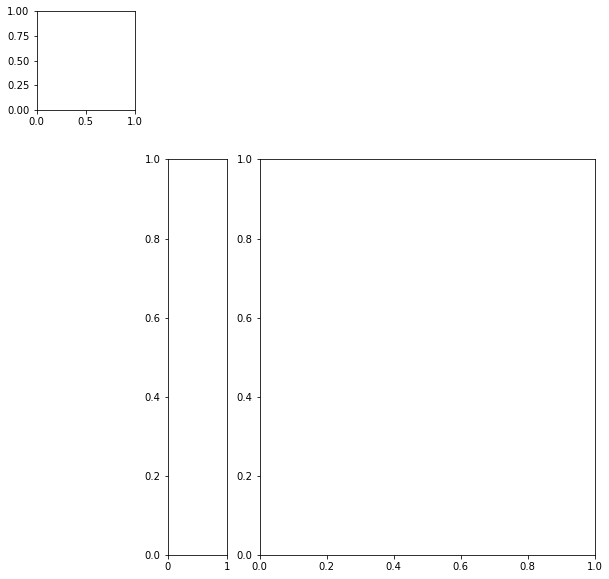

In [5]:
import signatureanalyzer as sa
from sklearn.preprocessing import StandardScaler

results = sa.ardnmf(spectra_snv, verbose=False)
data = results['Hraw'].transpose() / results['Hraw'].sum(axis=1)
#data = np.log1p(results['Hraw'].transpose())
meta = meta_filtered.reindex(data.index)
make_plots(data, meta, 'SNP_ALL')